## Data loading
### Loading the "sentimentdataset.csv" file into a Pandas DataFrame.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob
import missingno as msno
import string

# Load the dataset
file_path = "customer_support_tickets.csv"
df = pd.read_csv(file_path)

## **Step 1: Data Exploration**

## Display basic information about the dataset

In [55]:
df.info(), df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8469 entries, 0 to 8468
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ticket ID                     8469 non-null   int64  
 1   Customer Name                 8469 non-null   object 
 2   Customer Email                8469 non-null   object 
 3   Customer Age                  8469 non-null   int64  
 4   Customer Gender               8469 non-null   object 
 5   Product Purchased             8469 non-null   object 
 6   Date of Purchase              8469 non-null   object 
 7   Ticket Type                   8469 non-null   object 
 8   Ticket Subject                8469 non-null   object 
 9   Ticket Description            8469 non-null   object 
 10  Ticket Status                 8469 non-null   object 
 11  Resolution                    2769 non-null   object 
 12  Ticket Priority               8469 non-null   object 
 13  Tic

(None,
    Ticket ID  Customer Name              Customer Email  Customer Age  \
 0          1  Marisa Obrien  carrollallison@example.com            32   
 1          2   Jessica Rios    clarkeashley@example.com            42   
 
   Customer Gender Product Purchased Date of Purchase      Ticket Type  \
 0           Other        GoPro Hero       22-03-2021  Technical issue   
 1          Female       LG Smart TV       22-05-2021  Technical issue   
 
              Ticket Subject  \
 0             Product setup   
 1  Peripheral compatibility   
 
                                   Ticket Description  \
 0  I'm having an issue with the {product_purchase...   
 1  I'm having an issue with the {product_purchase...   
 
                Ticket Status Resolution Ticket Priority Ticket Channel  \
 0  Pending Customer Response        NaN        Critical   Social media   
 1  Pending Customer Response        NaN        Critical           Chat   
 
   First Response Time Time to Resolution  Cust

## **Step 2: Data Cleaning & Preprocessing**

## Checking the missing value percentage

In [56]:
# Checking missing values percentage
missing_values = df.isnull().sum() / len(df) * 100
print(missing_values)

Ticket ID                        0.000000
Customer Name                    0.000000
Customer Email                   0.000000
Customer Age                     0.000000
Customer Gender                  0.000000
Product Purchased                0.000000
Date of Purchase                 0.000000
Ticket Type                      0.000000
Ticket Subject                   0.000000
Ticket Description               0.000000
Ticket Status                    0.000000
Resolution                      67.304286
Ticket Priority                  0.000000
Ticket Channel                   0.000000
First Response Time             33.286102
Time to Resolution              67.304286
Customer Satisfaction Rating    67.304286
dtype: float64


### Checking if any rows are completely empty or have excessive missing data to either to drop them or impute values.

In [57]:
# Checking rows with excessive missing values (more than 50% missing data)
threshold = len(df.columns) * 0.5
rows_to_drop = df[df.isnull().sum(axis=1) > threshold]

# Count of rows to drop (if any found in rows_to_drop_count)
rows_to_drop_count = len(rows_to_drop)

# Drop rows if they exist and save the cleaned dataset
if rows_to_drop_count > 0:
    df = df[df.isnull().sum(axis=1) <= threshold]

# Verify the dataset after potential drops
df.isnull().sum(), print(rows_to_drop_count)


0


(Ticket ID                          0
 Customer Name                      0
 Customer Email                     0
 Customer Age                       0
 Customer Gender                    0
 Product Purchased                  0
 Date of Purchase                   0
 Ticket Type                        0
 Ticket Subject                     0
 Ticket Description                 0
 Ticket Status                      0
 Resolution                      5700
 Ticket Priority                    0
 Ticket Channel                     0
 First Response Time             2819
 Time to Resolution              5700
 Customer Satisfaction Rating    5700
 dtype: int64,
 None)

### Decision on Dropping Rows:
*  Checked for rows with over 50% missing data, where None were found (0 rows dropped).

*  Kept all data intact, No unnecessary data loss.

*  Missing values exist only in "Time to Resolution" & "Resolution Time (hrs)", which are for unresolved tickets (intentionally done).

## Converting Date Columns to DateTime format

In [58]:
date_columns = ["Date of Purchase", "First Response Time", "Time to Resolution"]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')


<ipython-input-58-29fedc31f093>:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors='coerce')


### Create Derived Time Columns by calculating response time

In [59]:
# Calculating response time (difference between ticket creation and first response time)
df["Response Time (hrs)"] = (df["First Response Time"] - df["Date of Purchase"]).dt.total_seconds() / 3600

### Calculating resolution time

In [60]:
# Calculate resolution time (difference between first response and resolution time)
df["Resolution Time (hrs)"] = (df["Time to Resolution"] - df["First Response Time"]).dt.total_seconds() / 3600
df["Resolution Time (hrs)"].head(5)

,Resolution Time (hrs)
0,NaN
1,NaN
2,6.850000
3,-5.533333
4,19.683333


## Step 3: Cleaning Text Columns



### Standardizing Categorical Data for better analysis

In [61]:
# Step 4: Standardize Categorical Data
df["Customer Name"] = df["Customer Name"].str.title().str.strip()
df["Customer Email"] = df["Customer Email"].str.lower().str.strip()
df["Customer Gender"] = df["Customer Gender"].str.capitalize()
df["Ticket Type"] = df["Ticket Type"].str.lower()
df["Ticket Subject"] = df["Ticket Subject"].str.lower()
df["Ticket Status"] = df["Ticket Status"].str.lower()
df["Ticket Priority"] = df["Ticket Priority"].str.lower()
df["Ticket Channel"] = df["Ticket Channel"].str.lower()

### Handling Missing Values in response time and resolution time

In [62]:
# Filling missing satisfaction rating with median (which is neutral assumption)
df["Customer Satisfaction Rating"].fillna(df["Customer Satisfaction Rating"].median(), inplace=True)

# Filling missing response time and resolution time with median where possible
df["Response Time (hrs)"].fillna(df["Response Time (hrs)"].median(), inplace=True)
df["Resolution Time (hrs)"].fillna(df["Resolution Time (hrs)"].median(), inplace=True)

# Rechecking for missing values after cleaning
df.isnull().sum()

<ipython-input-62-601e21ee3de3>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Customer Satisfaction Rating"].fillna(df["Customer Satisfaction Rating"].median(), inplace=True)
<ipython-input-62-601e21ee3de3>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

,0
Ticket ID,0
Customer Name,0
Customer Email,0
Customer Age,0
Customer Gender,0
Product Purchased,0
Date of Purchase,0
Ticket Type,0
Ticket Subject,0
Ticket Description,0


### Further general cleaning to prepare for EDA

In [63]:
# Strip whitespace from column names and standardize them
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

# Handle "first_response_time" and "resolution_time_(hrs)" as numeric
if "first_response_time" in df.columns:
    df["first_response_time"] = pd.to_numeric(df["first_response_time"], errors='coerce')
    df["response_missing"] = df["first_response_time"].isna()

if "resolution_time_(hrs)" in df.columns:
    df["resolution_time_(hrs)"] = pd.to_numeric(df["resolution_time_(hrs)"], errors='coerce')

# Step 2: Summary Statistics
numerical_summary = df.describe(include=[np.number])
categorical_summary = df.select_dtypes(include="object").nunique()
missing_data = df.isnull().sum().sort_values(ascending=False)
ticket_type_counts = df["ticket_type"].value_counts() if "ticket_type" in df.columns else None

numerical_summary, categorical_summary, missing_data, ticket_type_counts


(         ticket_id  customer_age  first_response_time  \
 count  8469.000000   8469.000000         8.469000e+03   
 mean   4235.000000     44.026804        -2.179120e+18   
 std    2444.934048     15.296112         5.209480e+18   
 min       1.000000     18.000000        -9.223372e+18   
 25%    2118.000000     31.000000        -9.223372e+18   
 50%    4235.000000     44.000000         1.672983e+18   
 75%    6352.000000     57.000000         1.673016e+18   
 max    8469.000000     70.000000         1.675645e+18   
 
        customer_satisfaction_rating  response_time_(hrs)  \
 count                   8469.000000          8469.000000   
 mean                       2.997166         17726.767487   
 std                        0.804446          4088.388594   
 min                        1.000000          8931.133333   
 25%                        3.000000         15670.883333   
 50%                        3.000000         17739.133333   
 75%                        3.000000         1977

## Step 4: Visualizing Ticket Volume by Type



### Total Tickets by Type
### 1. Purpose:
To identify the most frequent types of customer issues raised in support tickets. This helps in recognizing which areas of service/product require the most attention or improvement.

### 2. Insights:
* The most reported ticket type(s) (e.g., Login
Issues, Billing Problems, etc.) indicate pain points customers face regularly.
* These areas may need more support resources, better user guides, or system improvements to reduce issue recurrence.

<ipython-input-64-989b731700ea>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ticket_type_counts.values, y=ticket_type_counts.index, palette="rocket")


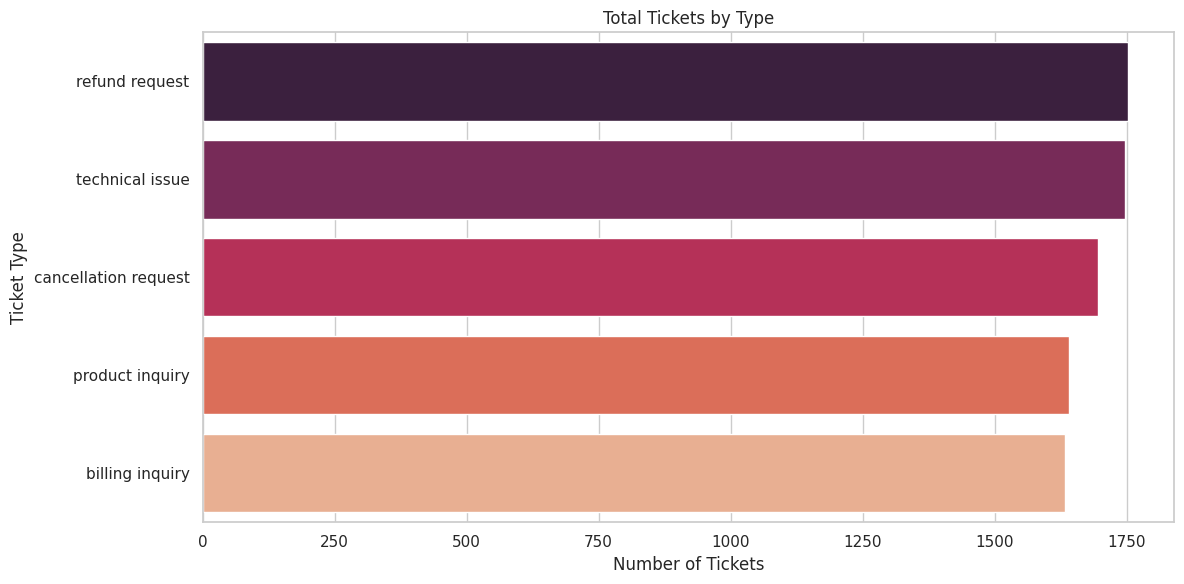

In [64]:
# Set visual style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Count of tickets by type
ticket_type_counts = df["ticket_type"].value_counts().sort_values(ascending=False)

# Count of tickets by type
ticket_type_counts = df["ticket_type"].value_counts().sort_values(ascending=False)

# Assuming 'Ticket Status' column indicates resolution status, creating a new 'is_resolved' column:
# If 'Ticket Status' is 'closed' or 'solved', then 'is_resolved' is True, otherwise False.
df['is_resolved'] = df['ticket_status'].apply(lambda x: x in ['closed', 'solved'])

# Count of resolution status per ticket type
ticket_type_resolution = df.groupby(["ticket_type", "is_resolved"]).size().unstack().fillna(0)

# Plot 1: Total ticket count by type
plt.figure(figsize=(12, 6))
sns.barplot(x=ticket_type_counts.values, y=ticket_type_counts.index, palette="rocket")
plt.title("Total Tickets by Type")
plt.xlabel("Number of Tickets")
plt.ylabel("Ticket Type")
plt.tight_layout()
plt.show()



### Ticket Volume Trend Over Time

### 1. Purpose:
To visualize how customer support ticket volume fluctuates over time (daily, weekly, monthly) to detect patterns, peak periods, or anomalies.

### 2. Insight:
* Helps with staffing, automation, or resource planning.
* Spikes may correlate with product updates, outages, or campaigns.

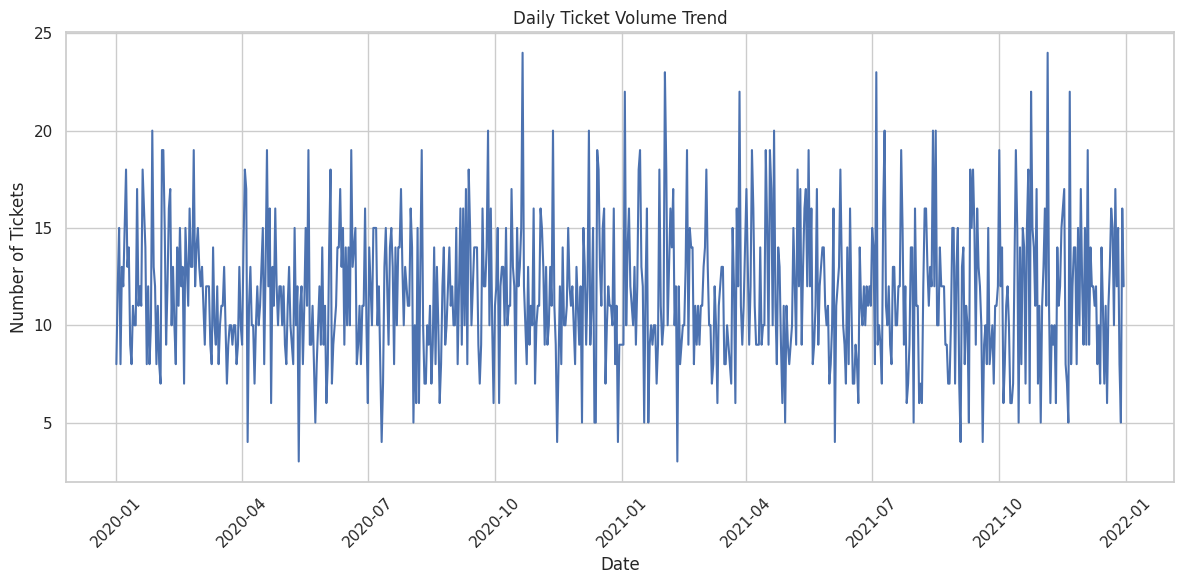

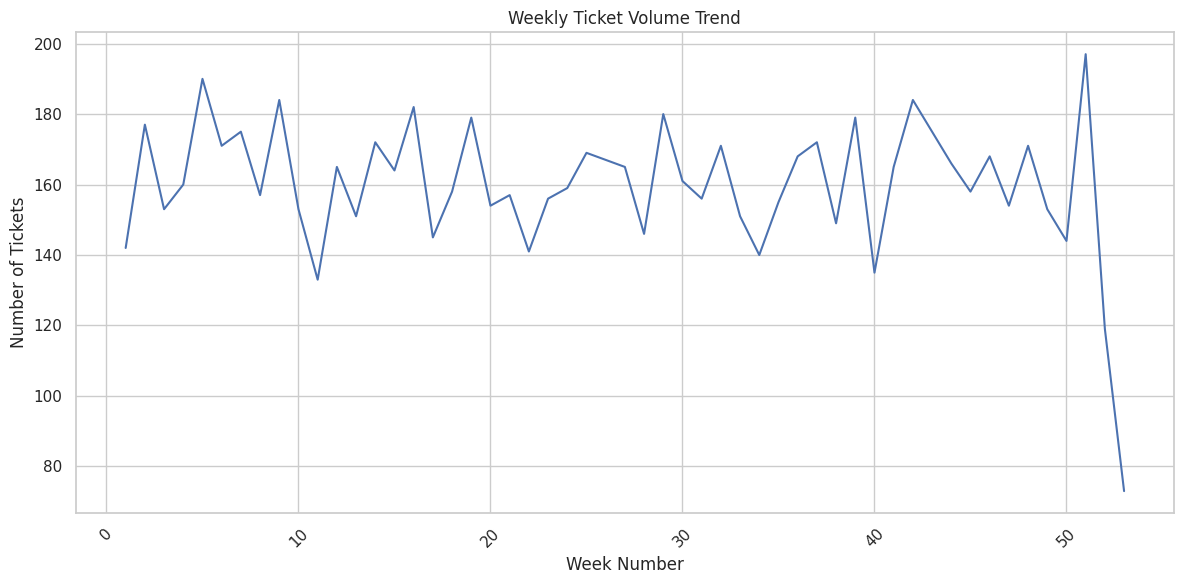

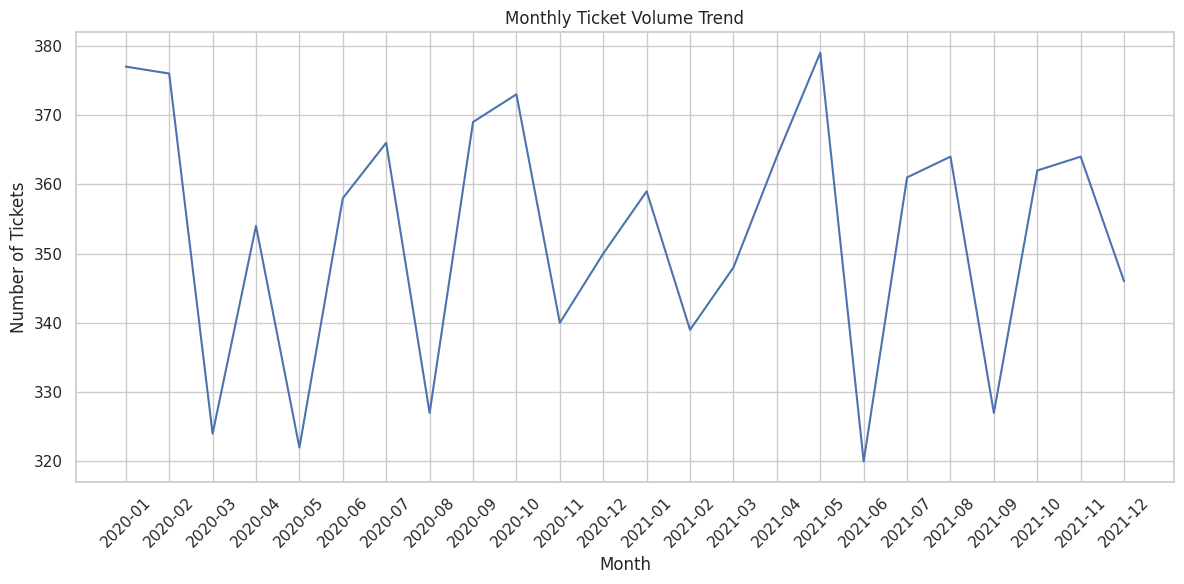

In [65]:
# Group by day and count tickets
daily_tickets = df.groupby(df['date_of_purchase'].dt.date).size()

# Plot daily ticket volume
plt.figure(figsize=(12, 6))
plt.plot(daily_tickets.index, daily_tickets.values)
plt.xlabel('Date')
plt.ylabel('Number of Tickets')
plt.title('Daily Ticket Volume Trend')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Group by week and count tickets
weekly_tickets = df.groupby(df['date_of_purchase'].dt.isocalendar().week).size()

# Plot weekly ticket volume
plt.figure(figsize=(12, 6))
plt.plot(weekly_tickets.index, weekly_tickets.values)
plt.xlabel('Week Number')
plt.ylabel('Number of Tickets')
plt.title('Weekly Ticket Volume Trend')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Group by month and count tickets
monthly_tickets = df.groupby(df['date_of_purchase'].dt.to_period('M')).size()

# Plot monthly ticket volume
plt.figure(figsize=(12, 6))
plt.plot(monthly_tickets.index.astype(str), monthly_tickets.values) # Convert PeriodIndex to string for plotting
plt.xlabel('Month')
plt.ylabel('Number of Tickets')
plt.title('Monthly Ticket Volume Trend')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Resolved vs Not Resolved by Ticket Type

### 1.  Purpose:
To evaluate the efficiency of the support team in resolving different types of tickets and identify issue categories that are frequently left unresolved.

### 2.  Insights:
* Some ticket types (like Technical Issues) may have higher unresolved counts — indicating complexity or gaps in agent knowledge.

* Ticket types with high resolution rates show areas where support processes are working well.

* This visualization will help optimize workflows, assign experienced agents to tougher issues, or trigger escalations.

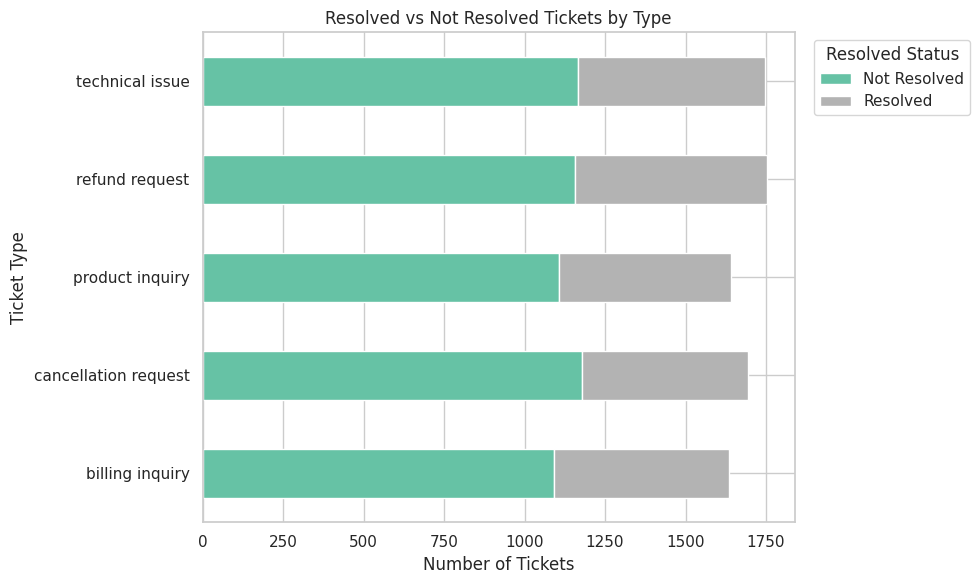

In [66]:
ticket_type_resolution.plot(kind='barh', stacked=True, colormap='Set2')
plt.title("Resolved vs Not Resolved Tickets by Type")
plt.xlabel("Number of Tickets")
plt.ylabel("Ticket Type")
plt.legend(title="Resolved Status", labels=["Not Resolved", "Resolved"], bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

## Channel-wise Ticket Trends (Email, Chat, Phone, etc.)

### 1.  Purpose:
To understand which communication channels customers prefer or rely on most when seeking support.

### 2.  Insights (Expected):
* Higher ticket volume on a specific channel (e.g., Email or Chat) may suggest customer preference or ease of use.

* Channels with lower ticket volumes might be underutilized or need better promotion or integration.

<ipython-input-67-c6653b07af75>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=channel_counts.values, y=channel_counts.index, palette="pastel")


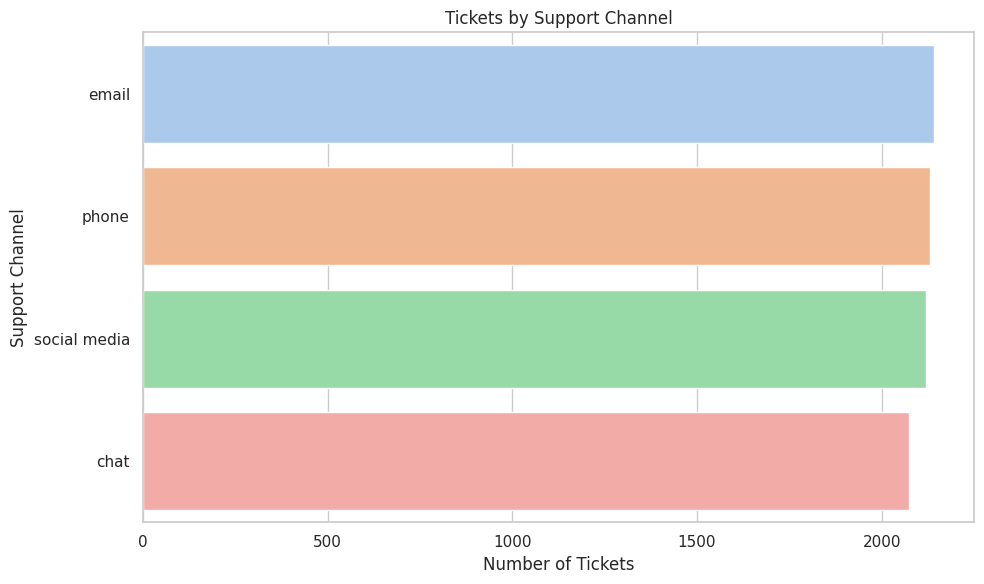

In [67]:
channel_counts = df["ticket_channel"].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=channel_counts.values, y=channel_counts.index, palette="pastel")
plt.title("Tickets by Support Channel")
plt.xlabel("Number of Tickets")
plt.ylabel("Support Channel")
plt.tight_layout()
plt.show()

## Priority-wise Ticket Trends

### 1.  Purpose:
To assess the distribution of tickets across different priority levels — which helps in workload planning and urgency management.

### 2.  Insights (Expected):
* A large number of high-priority tickets could indicate product/service instability.

* If low-priority tickets dominate, it might suggest general customer queries or non-critical issues.

* Helps prioritize agent allocation and escalation policies.

<ipython-input-68-0731ce64b744>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=priority_counts.values, y=priority_counts.index, palette="rocket")


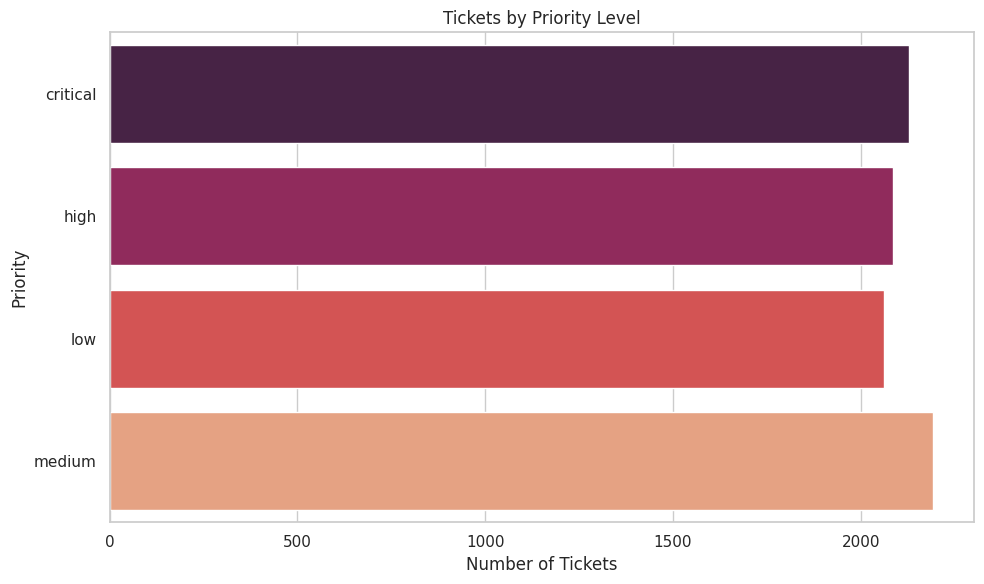

In [68]:
priority_counts = df["ticket_priority"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=priority_counts.values, y=priority_counts.index, palette="rocket")
plt.title("Tickets by Priority Level")
plt.ylabel("Priority")
plt.xlabel("Number of Tickets")
plt.tight_layout()
plt.show()

## Step 5: Visualization on Response & Resolution Timeliness

### Distribution of First Response Time & Resolution Time

### 1.  Purpose:
To analyze how quickly the support team responds to and resolves tickets overall.

### 2.  Insights (Expected):
* Helps identify if response/resolution times are generally fast or delayed.

* Outliers may indicate bottlenecks in support processes.

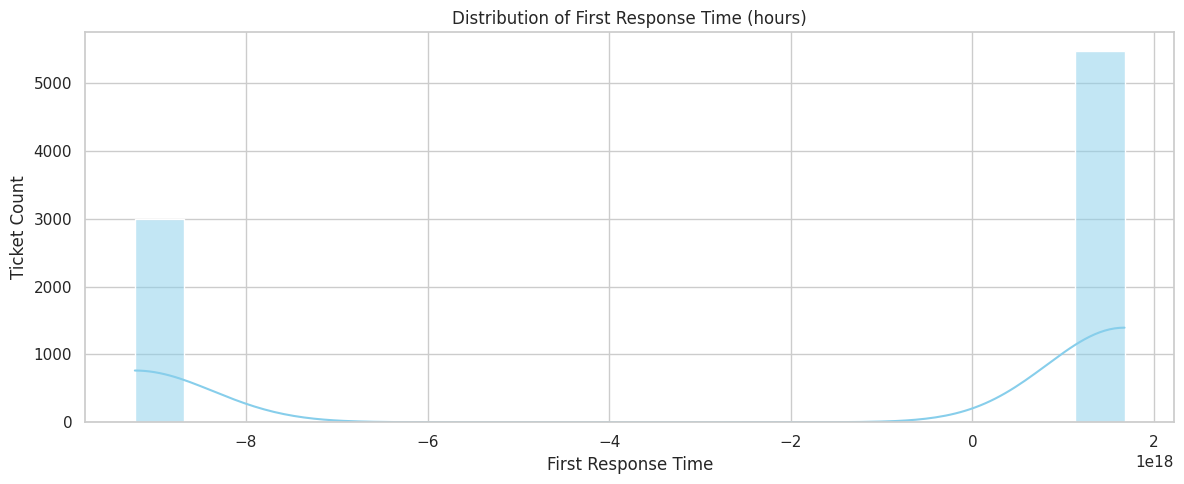

In [69]:
# Distribution of First Response Time
plt.figure(figsize=(12, 5))
sns.histplot(df['first_response_time'].dropna(), kde=True, bins=20, color='skyblue')
plt.title("Distribution of First Response Time (hours)")
plt.xlabel("First Response Time")
plt.ylabel("Ticket Count")
plt.tight_layout()
plt.show()

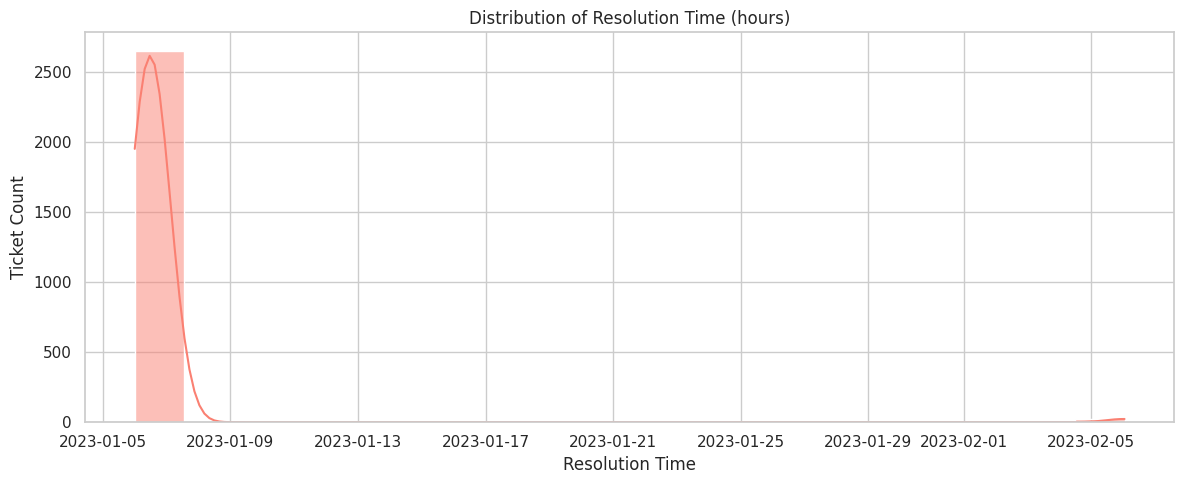

In [70]:
# Distribution of Resolution Time
plt.figure(figsize=(12, 5))
sns.histplot(df['time_to_resolution'].dropna(), kde=True, bins=20, color='salmon')
plt.title("Distribution of Resolution Time (hours)")
plt.xlabel("Resolution Time")
plt.ylabel("Ticket Count")
plt.tight_layout()
plt.show()

### Compare Timeliness Between Resolved vs Unresolved Tickets

### 1.  Purpose:
To evaluate whether tickets that remain unresolved had slower responses or resolution attempts.
### 2.  Insights (Expected):
* If unresolved tickets consistently show higher response/resolution times, delays may be contributing to unresolved outcomes.

* Helps improve ticket triaging processes.

<ipython-input-71-2262805de08f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='is_resolved', y='first_response_time', palette='Set2')


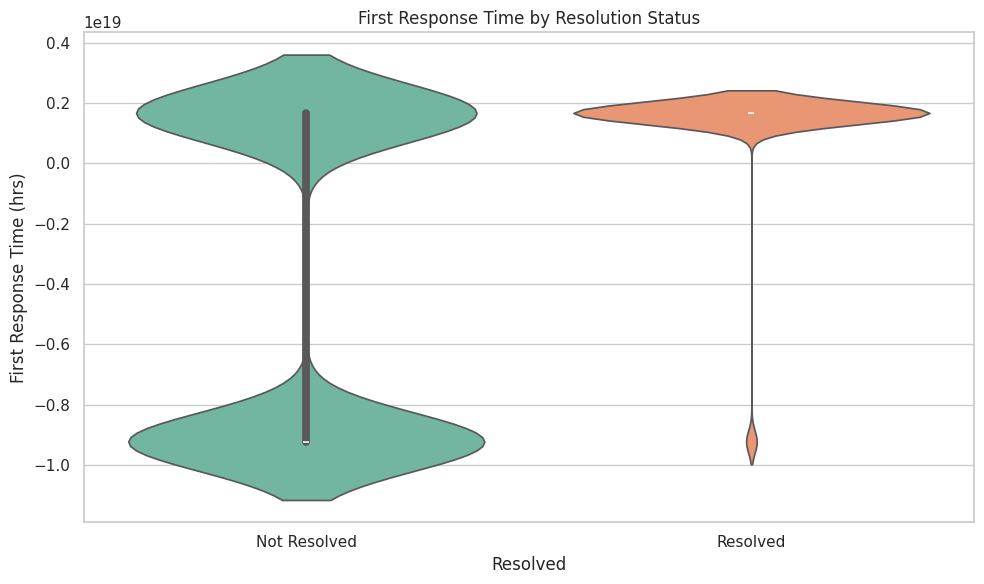

In [71]:
# Violin plot comparison: First Response Time by Resolution Status
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='is_resolved', y='first_response_time', palette='Set2')
plt.title("First Response Time by Resolution Status")
plt.xlabel("Resolved")
plt.ylabel("First Response Time (hrs)")
plt.xticks([0, 1], ['Not Resolved', 'Resolved'])
plt.tight_layout()
plt.show()

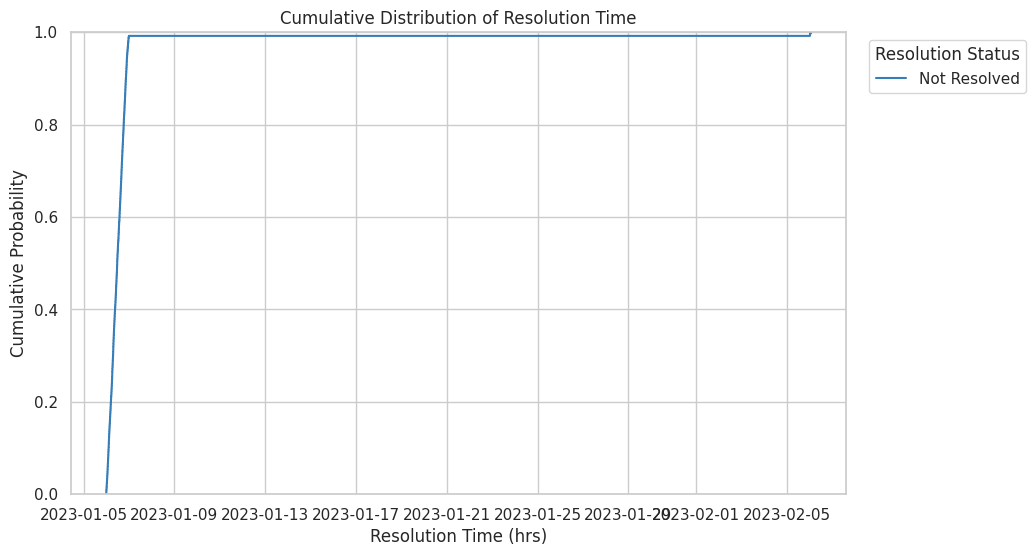

In [72]:
# Cumulative Distribution Function (CDF) plot comparison: Resolution Time by Resolution Status
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df, x='time_to_resolution', hue='is_resolved', palette='Set1')
plt.title("Cumulative Distribution of Resolution Time")
plt.xlabel("Resolution Time (hrs)")
plt.ylabel("Cumulative Probability")
plt.legend(title='Resolution Status', labels=['Not Resolved', 'Resolved'], bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()

### Impact of Priority on Response/Resolution Timeliness
### 1. Purpose:
To determine if higher priority tickets are actually being responded to and resolved faster.

### 2. Insights:
* Ideally, high-priority tickets should have lower response/resolution times.

* If not, it may signal the need to reassess SLAs or escalation policies.



<ipython-input-73-42ac4a568572>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='ticket_priority', y='first_response_time', palette='Blues')


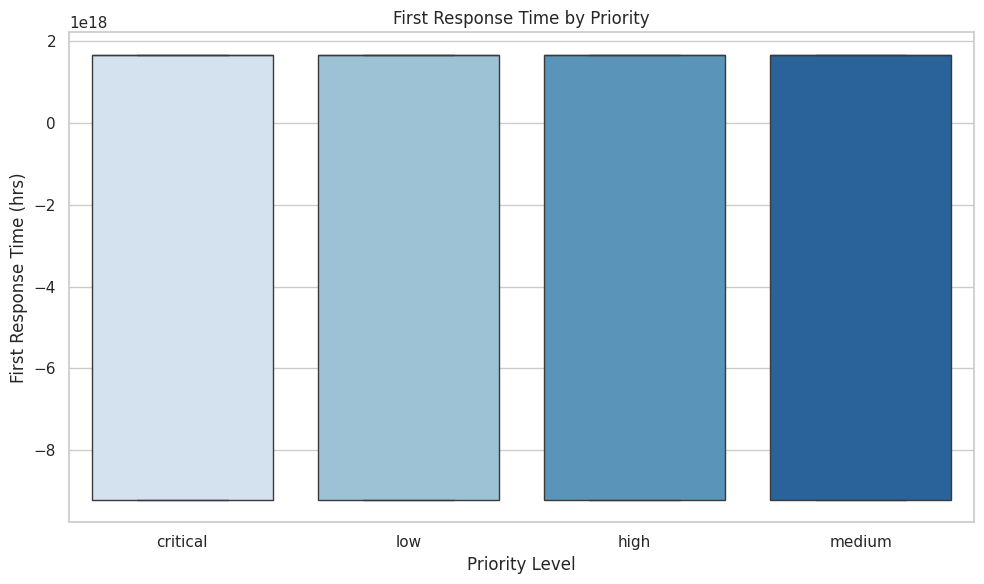

In [73]:
# Response Time by Priority
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='ticket_priority', y='first_response_time', palette='Blues')
plt.title("First Response Time by Priority")
plt.xlabel("Priority Level")
plt.ylabel("First Response Time (hrs)")
plt.tight_layout()
plt.show()

<ipython-input-74-b5b101ab1aca>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


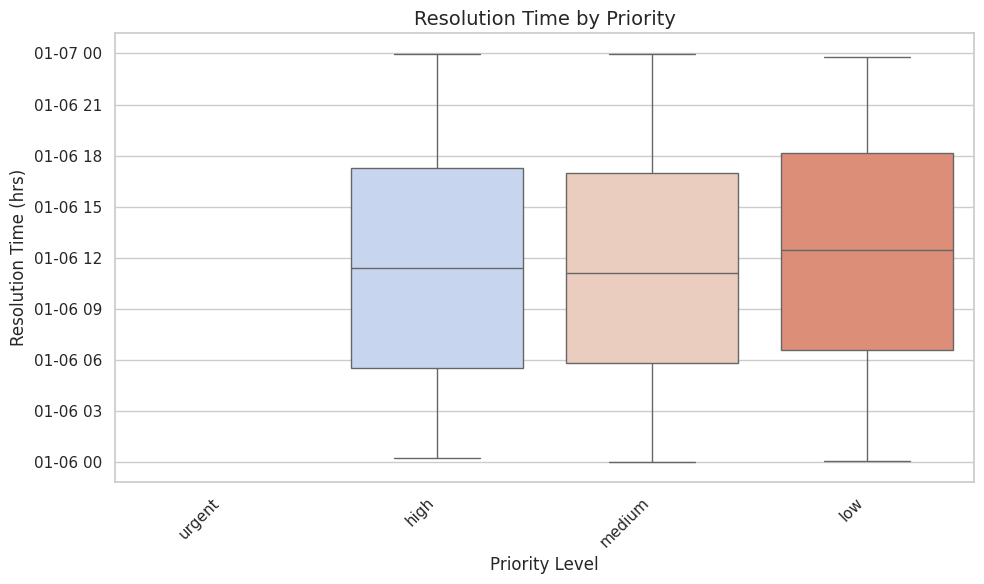

In [74]:
# Resolution Time by Priority
plt.figure(figsize=(10, 6))
priority_order = ["urgent", "high", "medium", "low"]
sns.boxplot(
    data=df,
    x="ticket_priority",
    y="time_to_resolution",
    palette="coolwarm",
    order=priority_order,  # Applying order
    showfliers=False,  # removing outliers for clarity
)

plt.title("Resolution Time by Priority", fontsize=14)
plt.xlabel("Priority Level", fontsize=12)
plt.ylabel("Resolution Time (hrs)", fontsize=12)
plt.xticks(rotation=45, ha="right")  # Rotating x-axis labels for better readability
plt.tight_layout()
plt.show()

## Step 6: Visualization on Customer Satisfaction & Experience

### Distribution of Satisfaction Ratings
### 1. Purpose:
To understand overall customer sentiment by analyzing how customers rate their support experience.

### 2. Insights (Expected):
* A concentration of high ratings suggests a strong support system.

* A large number of low ratings signals customer dissatisfaction and potential service gaps.

<ipython-input-75-b20d626e822f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='customer_satisfaction_rating', palette='coolwarm')


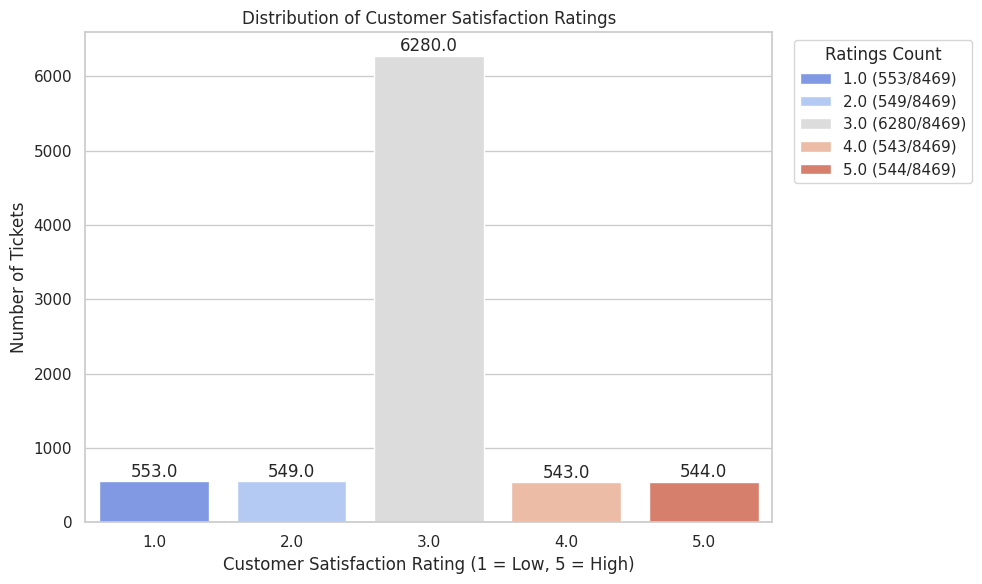

In [75]:
# Satisfaction Rating Distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='customer_satisfaction_rating', palette='coolwarm')
plt.title("Distribution of Customer Satisfaction Ratings")
plt.xlabel("Customer Satisfaction Rating (1 = Low, 5 = High)")
plt.ylabel("Number of Tickets")

# Adding count numbers on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + 0.4, p.get_height() + 5), ha='center', va='bottom')

# Displaying ratings count in the legend
total_ratings = df['customer_satisfaction_rating'].count()
ratings_counts = df['customer_satisfaction_rating'].value_counts().sort_index()
legend_labels = [f'{rating} ({count}/{total_ratings})' for rating, count in ratings_counts.items()]
ax.legend(legend_labels, title="Ratings Count", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

### Satisfaction vs Response & Resolution Time
### 1. Purpose:
To explore whether slower response and resolution times negatively impact customer satisfaction.

### 2. Insights (Expected):
* A visible drop in satisfaction with longer response or resolution times confirms the importance of timeliness.

* Helps define SLA targets and agent performance benchmarks.

<ipython-input-76-8b5e8c63cd08>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='customer_satisfaction_rating', y='first_response_time', palette='coolwarm')


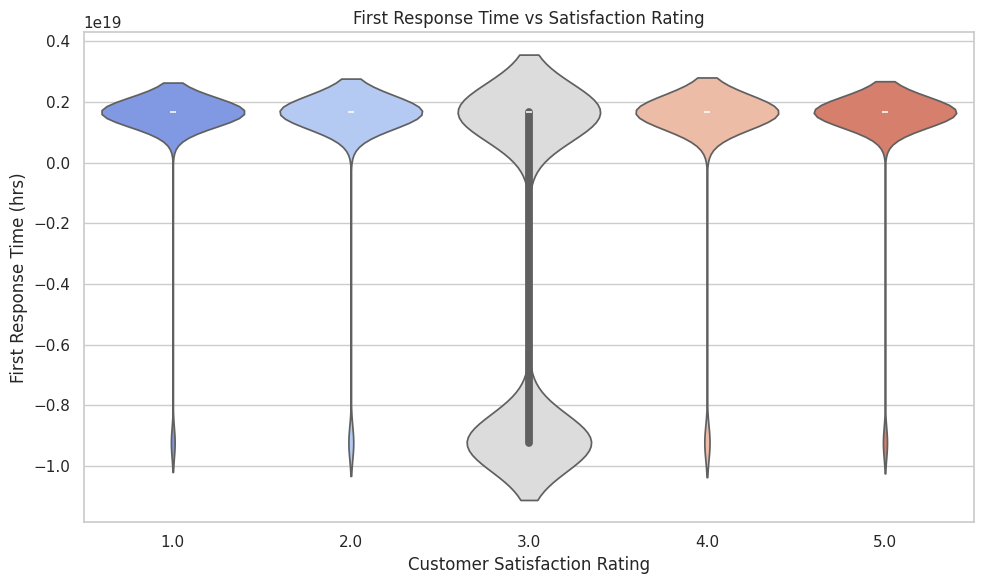

In [76]:
# Convert satisfaction_rating to categorical for better visuals
df['satisfaction_rating'] = df['customer_satisfaction_rating'].astype('category')

# First Response Time vs Satisfaction – Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='customer_satisfaction_rating', y='first_response_time', palette='coolwarm')
plt.title("First Response Time vs Satisfaction Rating")
plt.xlabel("Customer Satisfaction Rating")
plt.ylabel("First Response Time (hrs)")
plt.tight_layout()
plt.show()


<ipython-input-77-2400baaffb22>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=df_filtered, x='customer_satisfaction_rating', y='time_to_resolution', palette='coolwarm')


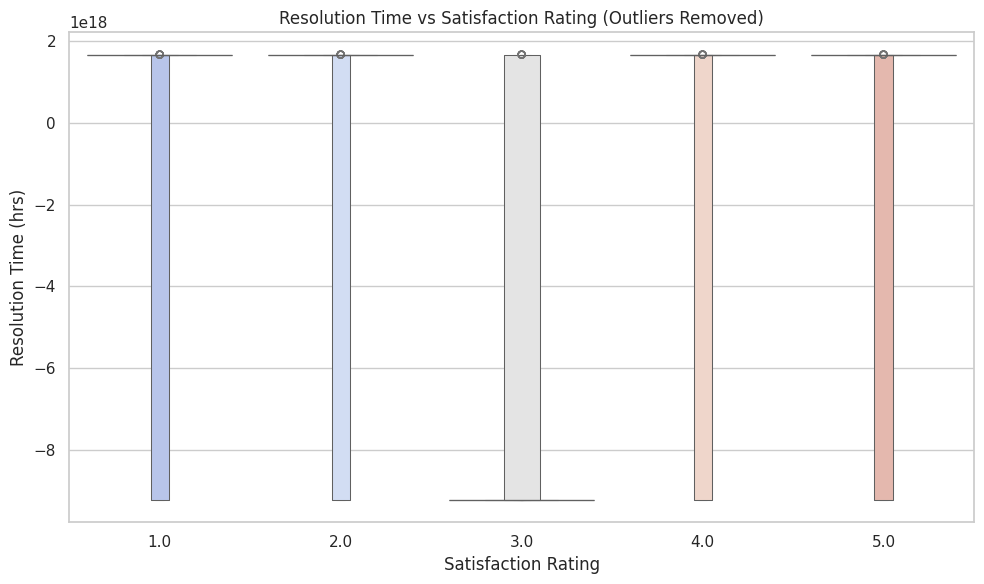

In [77]:
# Resolution Time vs Satisfaction
# Convert resolution time to numeric if needed (e.g., if it's a string or timedelta)
df['time_to_resolution'] = pd.to_numeric(df['time_to_resolution'], errors='coerce')
# Remove top 5% extreme values for cleaner plot
resolution_threshold = df['time_to_resolution'].quantile(0.95)
df_filtered = df[df['time_to_resolution'] <= resolution_threshold]

plt.figure(figsize=(10, 6))
sns.boxenplot(data=df_filtered, x='customer_satisfaction_rating', y='time_to_resolution', palette='coolwarm')
plt.title("Resolution Time vs Satisfaction Rating (Outliers Removed)")
plt.xlabel("Satisfaction Rating")
plt.ylabel("Resolution Time (hrs)")
plt.tight_layout()
plt.show()

### Satisfaction by Ticket Type
### 1.  Purpose:
To evaluate how different types of support issues affect customer satisfaction levels.

### 2.  Insights:
* Some ticket types may lead to consistently lower satisfaction — these should be prioritized for process improvement.

* Helps tailor responses and agent specialization per ticket type.

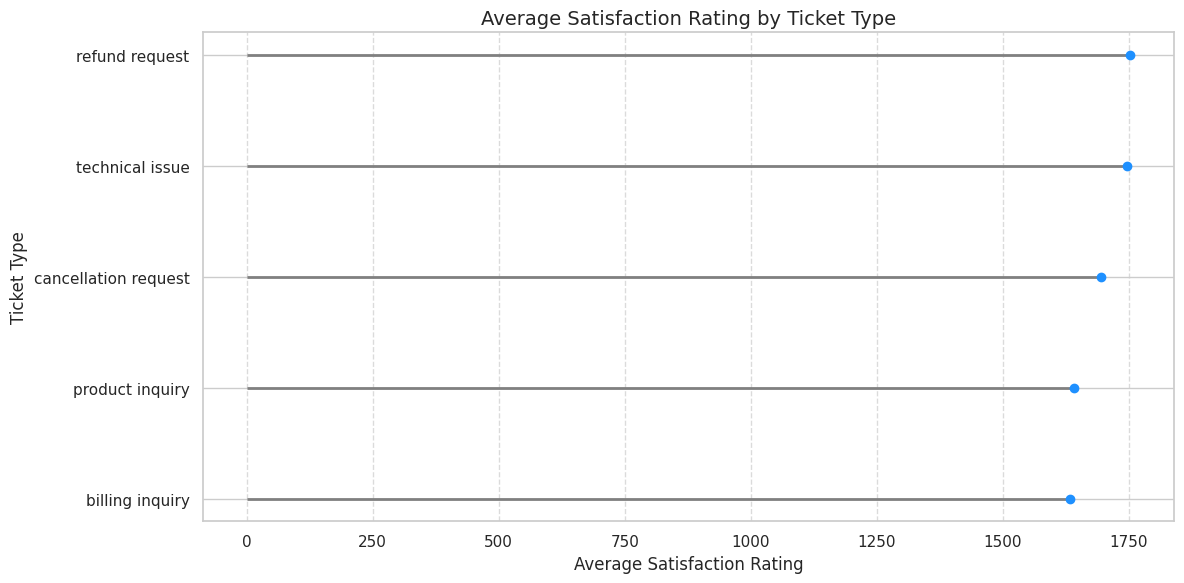

In [78]:
# Mean satisfaction rating by ticket type
type_satisfaction = df.groupby('ticket_type')['satisfaction_rating'].count().sort_values()

# Plot – Lollipop Chart
plt.figure(figsize=(12, 6))
plt.hlines(y=type_satisfaction.index, xmin=0, xmax=type_satisfaction.values, color='gray', linewidth=2)
plt.plot(type_satisfaction.values, type_satisfaction.index, "o", color='dodgerblue')
plt.title("Average Satisfaction Rating by Ticket Type", fontsize=14)
plt.xlabel("Average Satisfaction Rating")
plt.ylabel("Ticket Type")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Step 7: Visualizing on Top Performers & Problem Areas

### Most Active Customers
### 1.  Purpose:
Identify customers who generate the most tickets – useful for: Priority support, Relationship management, Identifying pain points for specific clients.
### 2.  Insights:
* Shows which clients raise the most issues.

* May indicate high-value or high-friction accounts.

* Helps prioritize proactive outreach or support automation.

<ipython-input-79-b6b89927ef41>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_customers.values, y=top_customers.index, palette="crest")


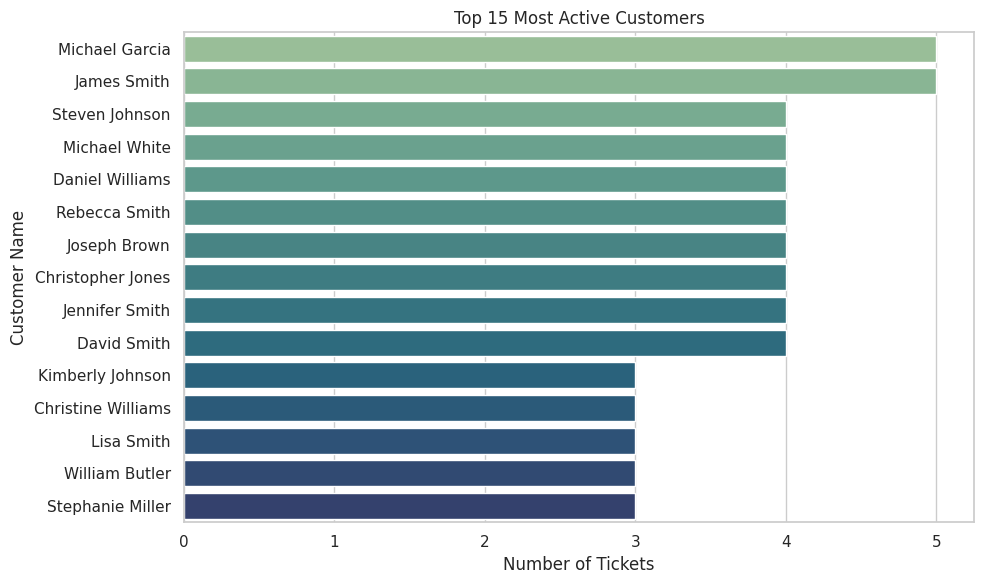

In [79]:
# Count tickets per customer (by email)
top_customers = df['customer_name'].value_counts().head(15)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_customers.values, y=top_customers.index, palette="crest")
plt.title("Top 15 Most Active Customers")
plt.xlabel("Number of Tickets")
plt.ylabel("Customer Name")
plt.tight_layout()
plt.show()


### Channels with Most Low Satisfaction Ratings

### 1. Purpose:
To identify which support channels (Email, Chat, Phone, etc.) are leading to poor customer experience.

### 2. Insights:
* Spot channels needing training, automation, or process improvement.

* Highlights if certain channels consistently fail to meet expectations.

* Helps optimize support channel strategy.



<ipython-input-80-297b7ddd3395>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_rated['channel'] = low_rated['ticket_channel'].fillna('Unknown').str.title()
<ipython-input-80-297b7ddd3395>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=channel_counts, x='Low Ratings Count', y='Channel', palette='mako')


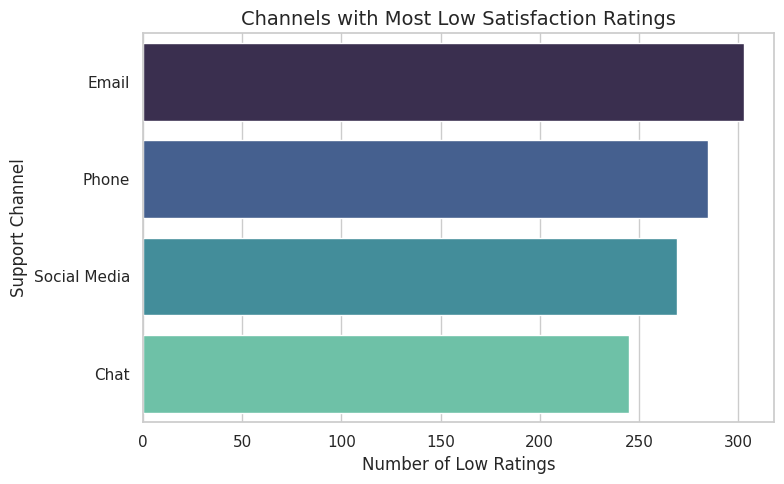

In [80]:
# Filter for low-rated tickets
low_rated = df[df['customer_satisfaction_rating'].isin([1, 2])]

# Handle missing or inconsistent channel data
low_rated['channel'] = low_rated['ticket_channel'].fillna('Unknown').str.title()

# Count low ratings by channel
channel_counts = low_rated['channel'].value_counts().reset_index()
channel_counts.columns = ['Channel', 'Low Ratings Count']

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=channel_counts, x='Low Ratings Count', y='Channel', palette='mako')
plt.title("Channels with Most Low Satisfaction Ratings", fontsize=14)
plt.xlabel("Number of Low Ratings")
plt.ylabel("Support Channel")
plt.tight_layout()
plt.show()

### Products with Most Support Tickets

### 1.  Purpose:
Discover which products or services need the most support attention.

### Insights:
* Helps flag high-maintenance or problematic products.

* These products may require better onboarding, documentation, or feature upgrades.



<ipython-input-81-62fb3757ad4e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette="flare")


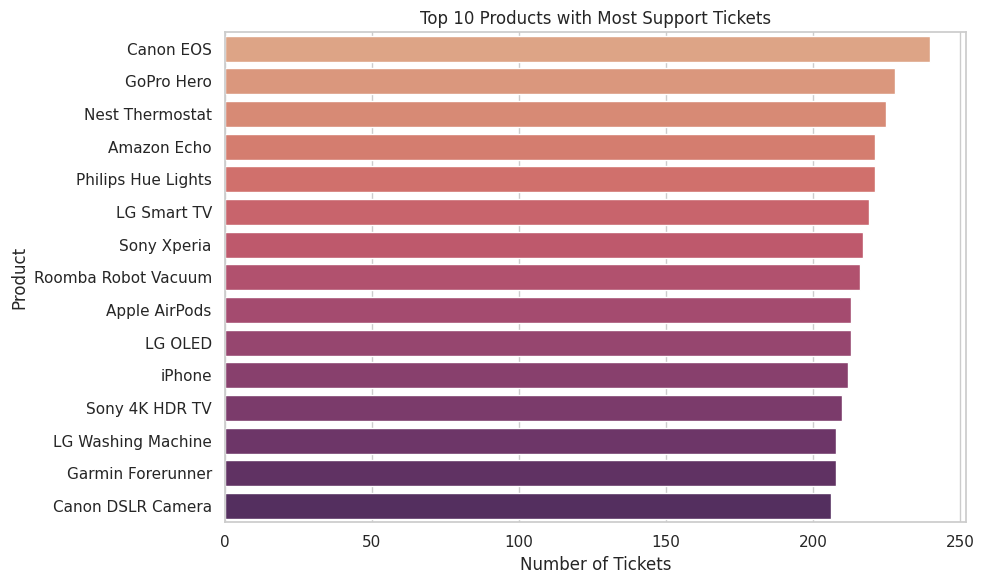

In [81]:
# Top 15 products by ticket count
top_products = df['product_purchased'].value_counts().head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette="flare")
plt.title("Top 10 Products with Most Support Tickets")
plt.xlabel("Number of Tickets")
plt.ylabel("Product")
plt.tight_layout()
plt.show()


## Step 8: Visualization on Text Analysis on Ticket Descriptions

### Keywords in Unsatisfied Tickets

### 1.  Purpose:
To visualize the most frequently mentioned words across all ticket descriptions, helping us identify general areas of concern or recurring keywords in customer queries.

### 2.  Insights:
* Highlights frustration keywords like “delay”, “refund”, “error”.

* Reveals recurring themes or feature complaints.

* Guides us product fixes or customer training.


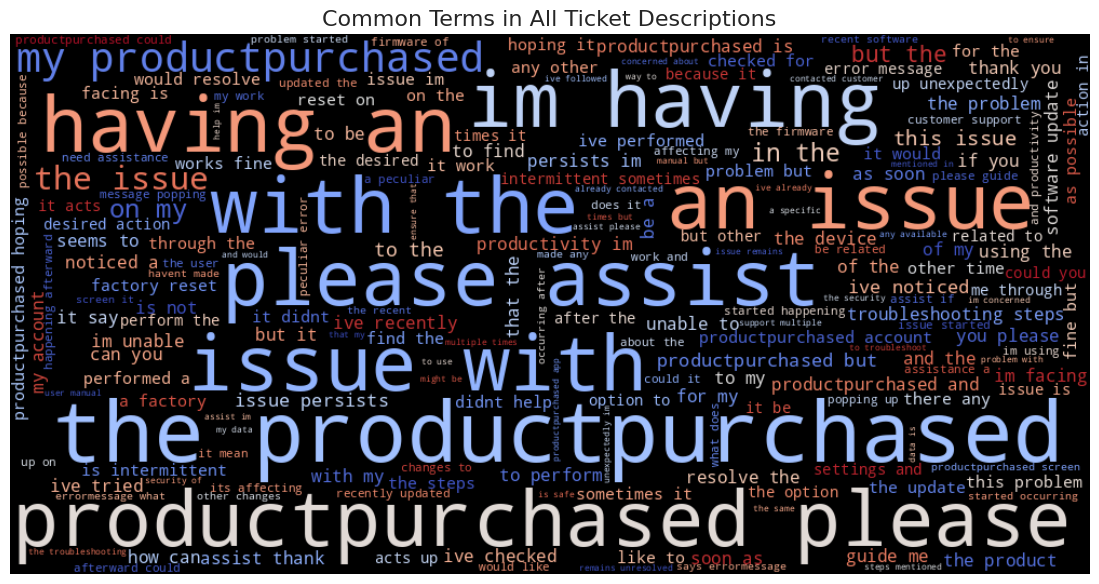

In [82]:
# Combine all descriptions
all_text = " ".join(df['ticket_description'].dropna().astype(str))

# Basic text cleaning
clean_text = all_text.lower().translate(str.maketrans('', '', string.punctuation))

# Generate and plot word cloud
wordcloud = WordCloud(width=1000, height=500, background_color='black', colormap='coolwarm', stopwords='english').generate(clean_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Terms in All Ticket Descriptions", fontsize=16)
plt.tight_layout()
plt.show()

### Unresolved Tickets by Status

### 1.  Purpose:
To visualize the volume of unresolved vs resolved tickets, helping quantify how often issues remain open and potentially frustrate users.

### 2.  Insights:
* Measures the effectiveness of the support system in closing tickets.

* Highlights the burden of pending issues that need attention.

* Indicates where resource allocation or workflow optimization may be needed.

<ipython-input-83-dffb2703ccbc>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='ticket_status', order=df['ticket_status'].value_counts().index, palette='coolwarm')


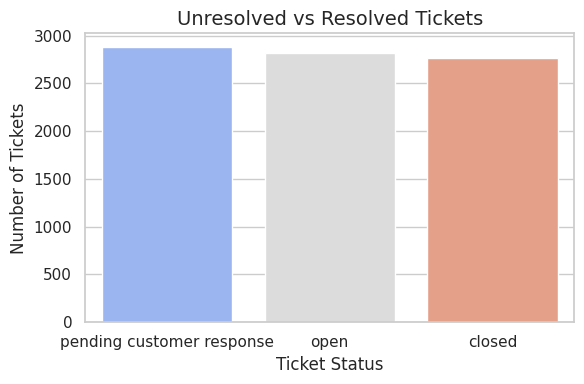

In [83]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='ticket_status', order=df['ticket_status'].value_counts().index, palette='coolwarm')
plt.title("Unresolved vs Resolved Tickets", fontsize=14)
plt.xlabel("Ticket Status")
plt.ylabel("Number of Tickets")
plt.tight_layout()
plt.show()

### Sentiment Analysis Polarity wise
### 1.   Purpose:
To analyze the emotional tone of customer descriptions, helping assess overall sentiment—whether customers are satisfied, neutral, or frustrated.
### 2.  Insights:
* The sentiment distribution shows a higher proportion of negative and neutral sentiments.
* Suggesting customers often reach out only when facing issues.
* This insight can guide proactive support improvements.

<ipython-input-84-d826e3d582f7>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment_label', palette='pastel')


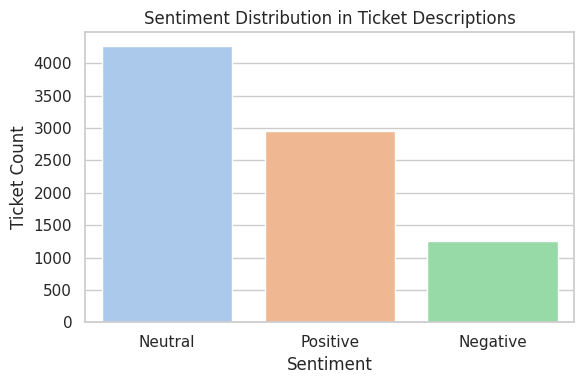

In [84]:
df['sentiment'] = df['ticket_description'].dropna().apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Classifying sentiment category
def get_sentiment(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'
df['sentiment_label'] = df['sentiment'].apply(get_sentiment)

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='sentiment_label', palette='pastel')
plt.title("Sentiment Distribution in Ticket Descriptions")
plt.xlabel("Sentiment")
plt.ylabel("Ticket Count")
plt.tight_layout()
plt.show()

### Customer Sentiment Trend Over Time

### 1. Purpose:
To visualize how customer sentiment evolves over time, revealing periods of increased dissatisfaction or improvements in customer experience.

### 2. Insight:
* Useful for identifying when frustration spikes—possibly due to outages, product changes, or internal delays so that we can correlate it with business events.

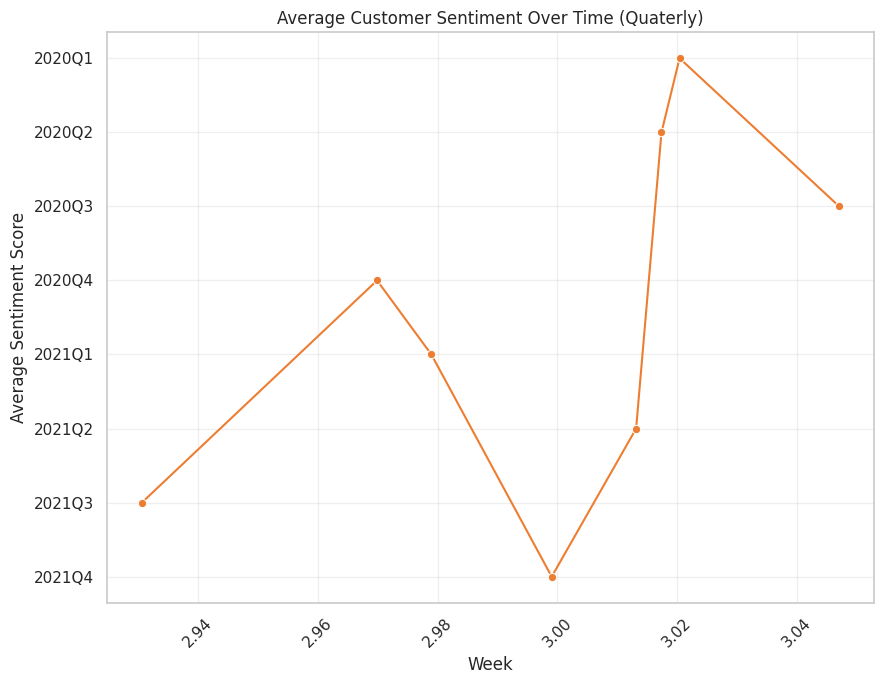

In [85]:
# Ensure created_date and sentiment_score are valid
df['created_date'] = pd.to_datetime(df['date_of_purchase'], errors='coerce')
df['sentiment_score'] = pd.to_numeric(df['customer_satisfaction_rating'], errors='coerce')

# Quaterly average sentiment
sentiment_trend = df.groupby(df['created_date'].dt.to_period('Q'))['sentiment_score'].mean().reset_index()
sentiment_trend['created_date'] = sentiment_trend['created_date'].astype(str)

plt.figure(figsize=(9, 7))
sns.lineplot(data=sentiment_trend, x='sentiment_score', y='created_date', marker='o', color='#ed7d31')
plt.title("Average Customer Sentiment Over Time (Quaterly)")
plt.xlabel("Week")
plt.ylabel("Average Sentiment Score")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Common Issues in Low Satisfaction Tickets

### 1. Purpose:
To discover which types of issues result in most dissatisfaction among users.

### 2. Insights:
* Uncovers problem areas needing resolution improvement.

* Enables theme-based process optimization.

* Supports training & automation where complaints are frequent.

<ipython-input-86-46e786e41118>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_rated['issue_category'] = low_rated['ticket_type'].fillna('Unknown').str.title()
<ipython-input-86-46e786e41118>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=issue_counts, y='Issue Category', x='Low Ratings Count', palette='coolwarm')


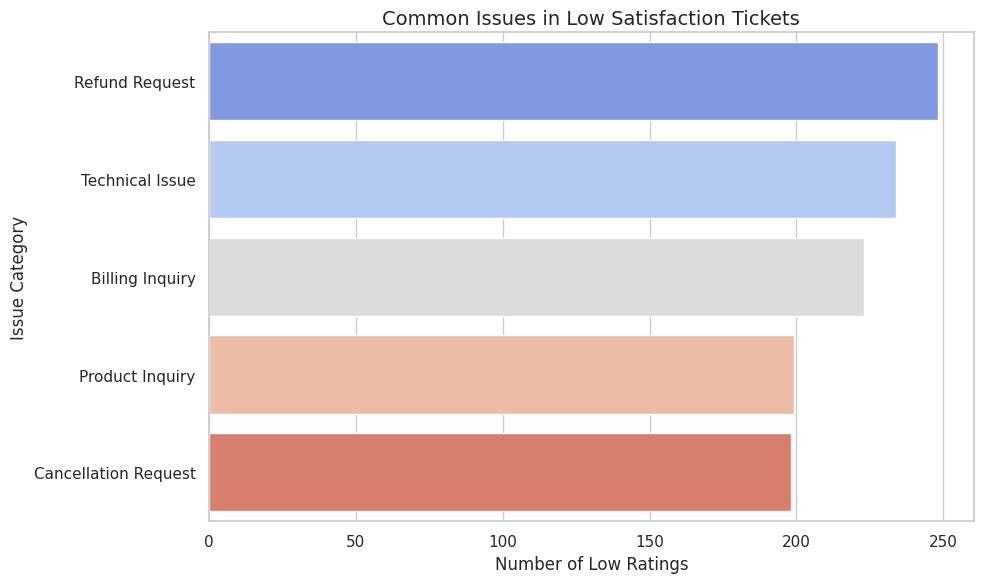

In [86]:
# Clean issue_category column
low_rated['issue_category'] = low_rated['ticket_type'].fillna('Unknown').str.title()

# Count low ratings by issue category
issue_counts = low_rated['issue_category'].value_counts().reset_index()
issue_counts.columns = ['Issue Category', 'Low Ratings Count']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=issue_counts, y='Issue Category', x='Low Ratings Count', palette='coolwarm')
plt.title("Common Issues in Low Satisfaction Tickets", fontsize=14)
plt.xlabel("Number of Low Ratings")
plt.ylabel("Issue Category")
plt.tight_layout()
plt.show()

### Grouping Tickets by Issue Themes (Data Categorization)

### 1.  Purpose:
Automatically categorize support tickets based on common issue themes using simple keyword matching for easier prioritization and trend tracking.

### 2.  Insight:
* Most tickets fall under categories like Login Issues, Payment Problems, and Technical Bugs.
* These can be flagged as high-priority problem areas for targeted resolution strategies or self-help documentation improvements.

<ipython-input-87-c40db6268ec7>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='issue_category', order=df['issue_category'].value_counts().index, palette='Set2')


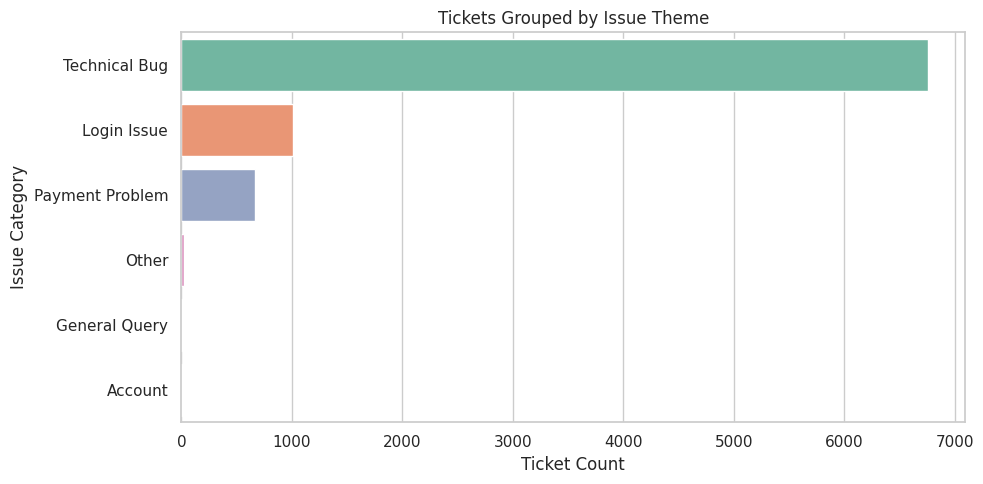

In [87]:
# Define some example issue themes
issue_keywords = {
    'Login Issue': [
        'login', 'sign in', 'signin', 'log in', 'password', 'access', 'authentication', 'reset', 'credentials', 'verification'
    ],
    'Payment Problem': [
        'payment', 'billing', 'charge', 'refund', 'invoice', 'receipt', 'card', 'transaction', 'pricing', 'subscription'
    ],
    'Technical Bug': [
        'error', 'bug', 'crash', 'freeze', 'fail', 'issue', 'technical', 'glitch', 'not working', 'problem'
    ],
    'Account': [
        'account', 'profile', 'settings', 'personal info', 'update info', 'edit profile', 'change name', 'delete account'
    ],
    'Delay': [
        'delay', 'slow', 'wait', 'pending', 'processing', 'time out', 'response time', 'loading', 'sluggish'
    ],
    'Cancellation/Return': [
        'cancel', 'return', 'refund', 'exchange'
    ],
    'General Query': [
        'help', 'support', 'question', 'query']
}


# Create a new column for issuing the categories that we made category
def categorize_issue(text):
    text = str(text).lower()
    for category, keywords in issue_keywords.items():
        if any(keyword in text for keyword in keywords):
            return category
    return 'Other'

df['issue_category'] = df['ticket_description'].apply(categorize_issue)

plt.figure(figsize=(10, 5))
sns.countplot(data=df, y='issue_category', order=df['issue_category'].value_counts().index, palette='Set2')
plt.title("Tickets Grouped by Issue Theme")
plt.xlabel("Ticket Count")
plt.ylabel("Issue Category")
plt.tight_layout()
plt.show()


### Monthly Trend of Unresolved Tickets

### 1.  Purpose:
To observe how the volume of unresolved tickets changes over time, helping detect backlogs, seasonal issues, or resource constraints.

### 2.  Insights Gained:
* Pinpoints months with spikes in unresolved tickets.

* Helps forecast workloads and prepare better resource allocation.

* Reveals support team efficiency trends over time.

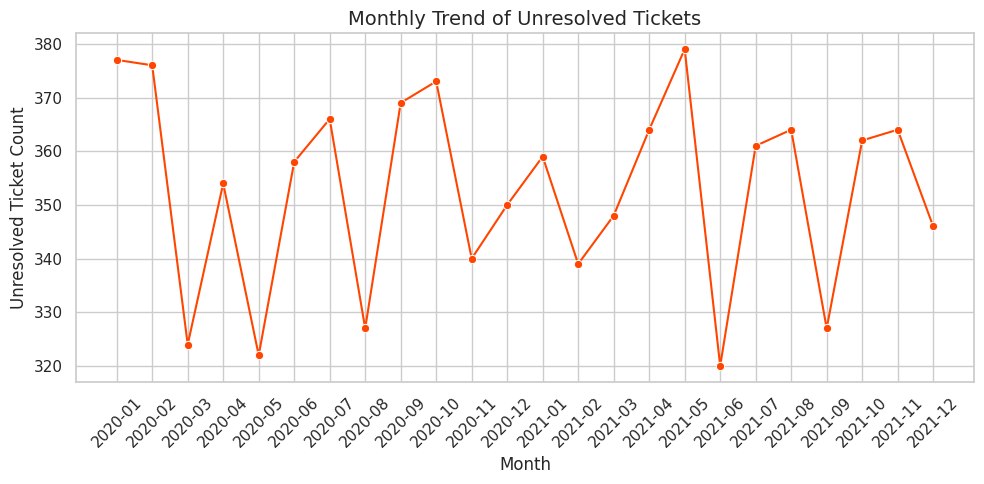

In [88]:
# Filtering unresolved tickets
unresolved = df[df['ticket_status'] != 'Resolved']

# Creating a month column using 'date_of_purchase'
unresolved['month'] = unresolved['date_of_purchase'].dt.to_period('M')

# Counting unresolved tickets by month
monthly_unresolved = unresolved.groupby('month').size().reset_index(name='unresolved_count')
monthly_unresolved['month'] = monthly_unresolved['month'].astype(str)  # for plotting

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_unresolved, x='month', y='unresolved_count', marker='o', color='orangered')
plt.title("Monthly Trend of Unresolved Tickets", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Unresolved Ticket Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Resolution Time Trend Over Time

### Purpose:
To analyze whether resolution time has improved or worsened over time.

### Insight:
* Identifies operational efficiency trends and evaluates the effectiveness of process or staffing changes.

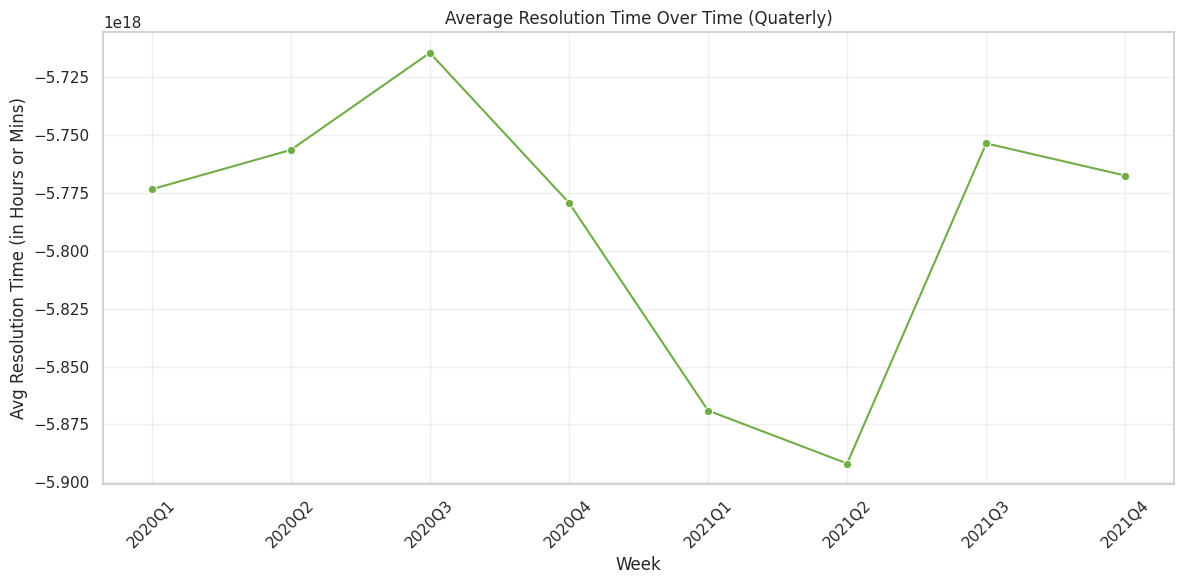

In [89]:
# Convert resolution time to numeric
df['time_to_resolution'] = pd.to_numeric(df['time_to_resolution'], errors='coerce')

# Quaterly average resolution time
resolution_trend = df.groupby(df['created_date'].dt.to_period('Q'))['time_to_resolution'].mean().reset_index()
resolution_trend['created_date'] = resolution_trend['created_date'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(data=resolution_trend, x='created_date', y='time_to_resolution', marker='o', color='#70ad47')
plt.title("Average Resolution Time Over Time (Quaterly)")
plt.xlabel("Week")
plt.ylabel("Avg Resolution Time (in Hours or Mins)")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Distribution of Low Satisfaction Ratings Across Ticket Priorities

### 1.  Purpose:
To understand whether critical or high-priority tickets are receiving low satisfaction ratings, which may indicate poor handling of urgent issues.

### 2.  Insights Gained:
* Reveals which ticket priorities correlate with poor customer experience.

* Helps determine if low ratings are tied to priority mismanagement.

* Assists in training, staffing, or process improvements for urgent issues

<ipython-input-90-324d8d2d2f01>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_rated['ticket_priority'] = low_rated['ticket_priority'].fillna('Unknown').str.title()
<ipython-input-90-324d8d2d2f01>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=low_rating_counts, x='Ticket Priority', y='Low Ratings Count', palette='rocket')


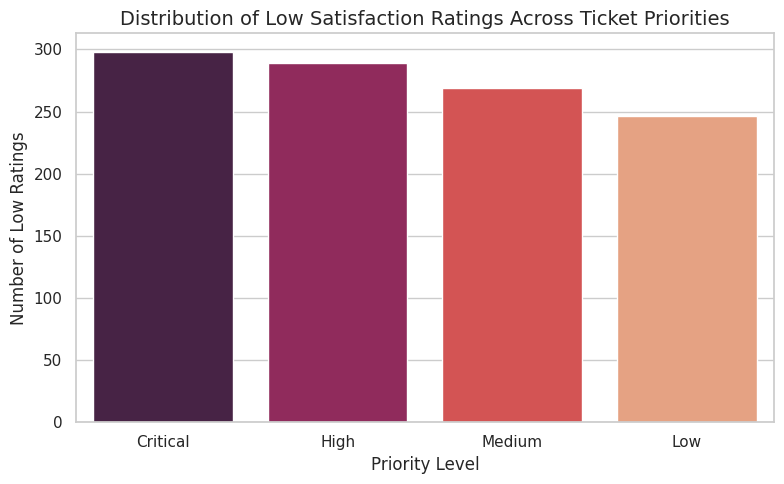

In [90]:
# Filter for tickets with low satisfaction ratings (assuming 1 and 2 are low)
low_rated = df[df['customer_satisfaction_rating'].isin([1, 2])]

# Standardize priority column
low_rated['ticket_priority'] = low_rated['ticket_priority'].fillna('Unknown').str.title()

# Order for clarity
priority_order = ['Critical', 'High', 'Medium', 'Low', 'Unknown']

# Count by ticket priority
low_rating_counts = low_rated['ticket_priority'].value_counts().reindex(priority_order).dropna().reset_index()
low_rating_counts.columns = ['Ticket Priority', 'Low Ratings Count']

plt.figure(figsize=(8, 5))
sns.barplot(data=low_rating_counts, x='Ticket Priority', y='Low Ratings Count', palette='rocket')
plt.title("Distribution of Low Satisfaction Ratings Across Ticket Priorities", fontsize=14)
plt.xlabel("Priority Level")
plt.ylabel("Number of Low Ratings")
plt.tight_layout()
plt.show()


### Heatmap of Low Satisfaction by Channel & Issue Type

### 1. Purpose:
To cross-analyze which channels are struggling with which types of issues, allowing for targeted intervention.

### 2. Insights Gained:
* Reveals channel-issue combinations that generate the most dissatisfaction.

* Prioritizes where to optimize workflows, retrain staff, or implement automated responses.

* Helps justify changes in channel handling or issue escalation strategies.

<ipython-input-91-68e841c90a24>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_rated['channel'] = low_rated['ticket_channel'].fillna('Unknown').str.title()
<ipython-input-91-68e841c90a24>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_rated['issue_category'] = low_rated['issue_category'].fillna('Unknown').str.title()


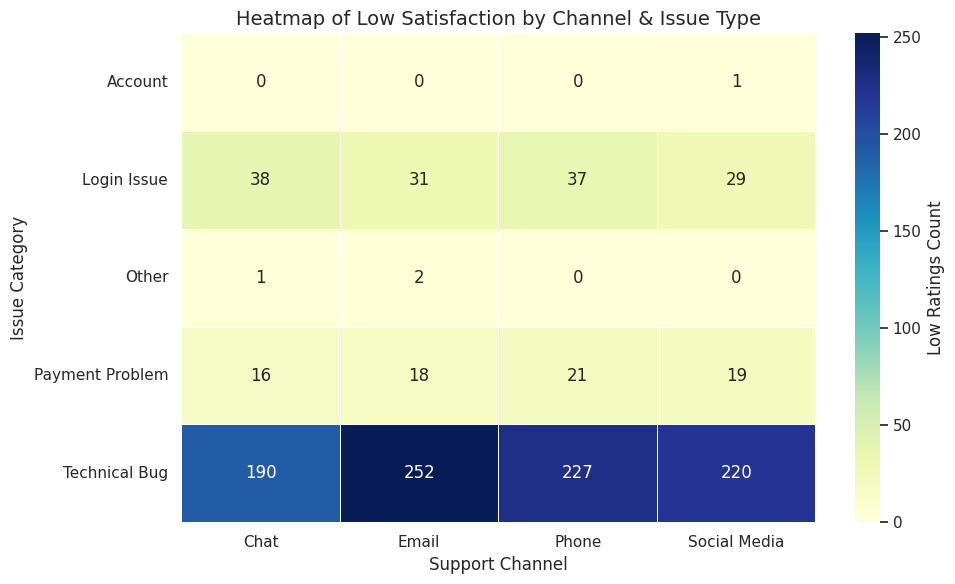

In [91]:
# Filter low satisfaction ratings (1 and 2)
low_rated = df[df['customer_satisfaction_rating'].isin([1, 2])]

# Clean data
low_rated['channel'] = low_rated['ticket_channel'].fillna('Unknown').str.title()
low_rated['issue_category'] = low_rated['issue_category'].fillna('Unknown').str.title()

# Create pivot table
heatmap_data = pd.pivot_table(
    low_rated,
    values='ticket_id',
    index='issue_category',
    columns='channel',
    aggfunc='count',
    fill_value=0
)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu', linewidths=0.5, cbar_kws={'label': 'Low Ratings Count'})
plt.title("Heatmap of Low Satisfaction by Channel & Issue Type", fontsize=14)
plt.xlabel("Support Channel")
plt.ylabel("Issue Category")
plt.tight_layout()
plt.show()
